# Paper 7
## Data cleaning
First, we import the data and remove all the information not needed: as we consider only data from the second floor,
we can remove al the other information.
Since we are considering only power demand, we can also remove temperature and humidity data.

In [2]:
import numpy as np
import pandas as pd
DATASET_PATH = 'AVGpower-1.csv'
SAMPLES = 4

dataset = pd.read_csv(DATASET_PATH, sep=';', parse_dates=['DateTime'])
dataset.drop(columns=['AvgT', 'AvgH'], inplace=True)
secondFloorData = dataset[dataset['CbTagName']=='CB Second Floor'].set_index("DateTime")
secondFloorData.drop('CbTagName', axis=1, inplace=True)
secondFloorData['DateTime'] = secondFloorData.index
secondFloorData.head(10)

,AvgP,DateTime
DateTime,,
2017-02-06 00:00:00,0,2017-02-06 00:00:00
2017-02-06 17:00:00,80,2017-02-06 17:00:00
2017-02-06 17:15:00,0,2017-02-06 17:15:00
2017-02-06 17:30:00,0,2017-02-06 17:30:00
2017-02-06 17:45:00,82,2017-02-06 17:45:00
2017-02-06 18:00:00,0,2017-02-06 18:00:00
2017-02-06 18:15:00,0,2017-02-06 18:15:00
2017-02-06 18:30:00,78,2017-02-06 18:30:00
2017-02-06 18:45:00,0,2017-02-06 18:45:00


As we can see, data from february 2017 are rare, so we can delete them.


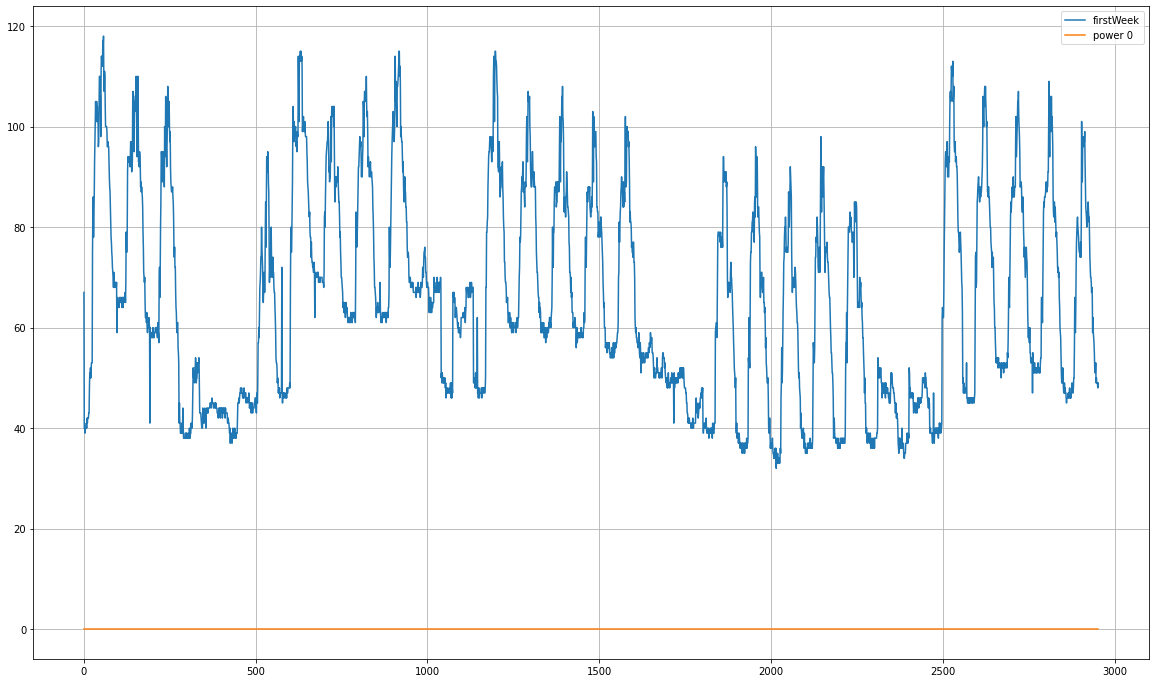

Missing values of the first week:0


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

secondFloorData2017 = secondFloorData[(secondFloorData['DateTime'].dt.year == 2017) & (secondFloorData['DateTime'].dt.month >=3)]
secondFloorData2018 = secondFloorData[secondFloorData['DateTime'].dt.year >= 2018]
secondFloorData = pd.concat([secondFloorData2017, secondFloorData2018])
secondFloorData = secondFloorData.set_index('DateTime')
secondFloorData['DateTime'] = secondFloorData.index

firstValues = secondFloorData2017[secondFloorData2017["DateTime"].dt.month <4]
powerDemand = firstValues['AvgP'].to_numpy()

fig, ax = plt.subplots(figsize=(20,12))
ax.plot([x for x in range(0, len(powerDemand))], powerDemand, label='firstWeek')
ax.plot([0, len(powerDemand)], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()


MissingDates = 0
for date in pd.date_range(start='2017-03-01', end='2017-03-08', freq='15m'):
    if date not in firstValues:
        MissingDates +=1
print('Missing values of the first week:' + str(MissingDates))

Samples are collected every 15 minutes but sometimes, they miss, or their value is 0. As these values are certainly incorrect,
we can try to correct them by assigning values of a week before.

First we introduce Nan values for each sample misses.

In [5]:
new_row = {name:[] for name in secondFloorData.columns}

for date in pd.date_range(start='2017-03-01', end=secondFloorData['DateTime'].max(), freq='15Min'):
    if date not in secondFloorData.index:
        new_row['DateTime'].append(date)
        new_row['AvgP'].append(np.nan)
secondFloorData = pd.concat([secondFloorData, pd.DataFrame(new_row)])
secondFloorData = secondFloorData.set_index("DateTime")
secondFloorData.sort_index(inplace=True)

All the missing values are replaced with meaningful values.

In [6]:
for i in range(672, len(secondFloorData)):
    if np.isnan(secondFloorData.iloc[i].AvgP) or secondFloorData.iloc[i].AvgP == 0:
        secondFloorData.iloc[i] = secondFloorData.iloc[i-672]
secondFloorData['DateTime'] = secondFloorData.index


We know the following dates are not holidays but power demand is low:
- 24/04/2017
- 14/08/2017
- 16/08/2017
- 17/08/2017
- 27/12/2017
- 28/12/2017
- 29/12/2017
- 01/01/2018
- 30/04/2018
- 13/08/2018
- 14/08/2018
- 02/11/2018
- 24/12/2018
- 27/12/2018
- 28/12/2018
- 31/12/2018

Whereas the following dates are holidays but power is high:
- 15/08/2018
- 26/12/2018

So, all the data that came from these dates are anomalies and need to be removed in order to delete noise.

In [7]:
def appendDay(listOfDays, day):
    day = day.split('/')
    day = day[2] + "-" + day[1] + "-" + day[0]
    listOfSamples = [x for x in pd.date_range(start=day+" 00:00", end=day+" 23:59", freq="1d")]
    for x in listOfSamples:
        listOfDays.append(x)
    return listOfDays

wrongWorkingDays = [
    "24/04/2017",
    "14/08/2017",
    "16/08/2017",
    "17/08/2017",
    "27/12/2017",
    "28/12/2017",
    "29/12/2017",
    "01/01/2018",
    "30/04/2018",
    "13/08/2018",
    "14/08/2018",
    "02/11/2018",
    "24/12/2018",
    "27/12/2018",
    "28/12/2018",
    "31/12/2018"
]

wrongHolidays = [
    "15/08/2018",
    "26/12/2018"
]

# anomalousWorkingDays is a list containing all the indexes of second floor data that have anomalies information about working days
anomalousWorkingDays = []
for x in wrongWorkingDays:
    anomalousWorkingDays = appendDay(anomalousWorkingDays, x)
print("anomalous working days are {}".format(len(anomalousWorkingDays)))

# anomalousHolidays is  a list containing all the indexes of second floor data that have anomalies information about holidays
anomalousHolidays = []
for x in wrongHolidays:
    anomalousHolidays = appendDay(anomalousHolidays, x)
print("anomalous holidays are {}".format(len(anomalousHolidays)))

anomalous working days are 16
anomalous holidays are 2


## Autoencoder
Goal of this project is to build 2 autoencoders: the former must be able to identify anomalies among working days, whereas
the latter has to recognize anomalies among holidays.

The idea is to train the first to rebuild working days: if the model is able to correctly rebuild the day, it means,
that it recognize it as a normal day, otherwise it will be an anomaly.
We can do the same considerations for the second auto encoder.

To maximize the performance we need to scale data to values between 0 and 1:

In [8]:
normalizedData = secondFloorData["AvgP"].to_numpy()
maximumValue = np.amax(normalizedData)
print(maximumValue)
normalizedData = normalizedData / maximumValue
maximumValue = np.amax(normalizedData)
print(maximumValue)


142.0
1.0


First we identify all the holidays dates.

In [9]:
import holidays

holidayDays = []
for date in holidays.Italy(years=[2017,2018,2019]).items():
    holidayDays.append(date[0])

We divide samples in samples collected during:
- normal working days
- normal holiday
- anomalous working day
- anomalous holiday

In [10]:
daySpan = SAMPLES * 24
row = 0
holidaySamples = []
workSamples = []
workAnomaliesSamples = []
holidayAnomaliesSamples = []
allSamples = []
# for each day, we represent each hour as the mean of the four samples collected during that hour and then is inserted
# into 'samples[]' vector.

for date in pd.date_range(start='2017-03-01', end='2019-04-09', freq='1d'):
    samplesPerDay = normalizedData[row : row + daySpan]
    samples = []
    # creation of a vector of 24 samples
    for index in range(24):
        firstIndex = index * SAMPLES
        samples.append(samplesPerDay[firstIndex : firstIndex + SAMPLES].mean())

    # the if/else chain is used to assign the vector to holidaySamples, workSamples, workAnomaliesSamples or anomalousWorkingDays
    if date in anomalousHolidays:
        holidayAnomaliesSamples.append(samples)
    elif date in anomalousWorkingDays:
        workAnomaliesSamples.append(samples)
    elif date.day_of_week == 5 or date.day_of_week == 6 or date in holidayDays:
        holidaySamples.append(samples)
    else:
        workSamples.append(samples)
    row += daySpan
    allSamples.append(samples)

print("Samples of normal holidays are {}".format(len(holidaySamples)))
print("Samples of normal work days are {}".format(len(workSamples)))
print("Samples of anomalous holidays are {}".format(len(holidayAnomaliesSamples)))
print("Samples of anomalous work days are {}".format(len(workAnomaliesSamples)))

Samples of normal holidays are 235
Samples of normal work days are 517
Samples of anomalous holidays are 2
Samples of anomalous work days are 16


Working days cleaned:

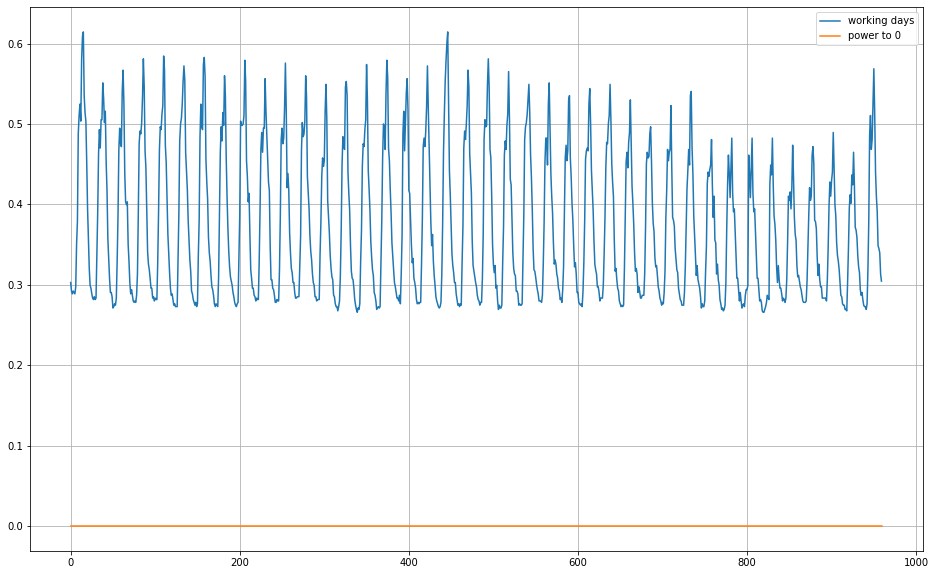

In [11]:
MONTH_SPAN = 40
START = MONTH_SPAN * 2   # per 2 si trovano i valori nulli che sono stati ricostruiti: sembrano ok.
y = workSamples[START : MONTH_SPAN + START]
y = np.array(y)
y = y.reshape(1, y.shape[0] * y.shape[1])[0]

FIG_SIZE = (16,10)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot([hour for hour in range(len(y))], y, label='working days')
ax.plot([0,len(y)], [0,0], label='power to 0')
ax.grid()
ax.legend()
plt.show()

In order to train these models we need to build a training set, and a testing set for each one.

In [12]:
def build_sets(set_to_convert):
    trainSet = []
    testSet = []
    PERCENTAGE = 0.8
    trainingSize = int(len(set_to_convert) * PERCENTAGE)
    for i in range(trainingSize):
        trainSet.append(set_to_convert[i])
    for i in range(trainingSize, len(set_to_convert)):
        testSet.append(set_to_convert[i])
    return trainSet, testSet


trainingAll, testAll = build_sets(allSamples)
trainingHolidays, testHolidays = build_sets(holidaySamples)
trainingWorkDays, testWorkDays = build_sets(workSamples)


print('training workdays dataset size :' + str(len(trainingWorkDays)))
print('training holidays dataset size :' + str(len(trainingHolidays)))
print('testing workdays dataset size : {}'.format(len(testWorkDays)))
print('testing holidays dataset size : {}'.format(len(testHolidays)))

training workdays dataset size :413
training holidays dataset size :188
testing workdays dataset size : 104
testing holidays dataset size : 47


Example of difference between a working day sample, and a holiday sample

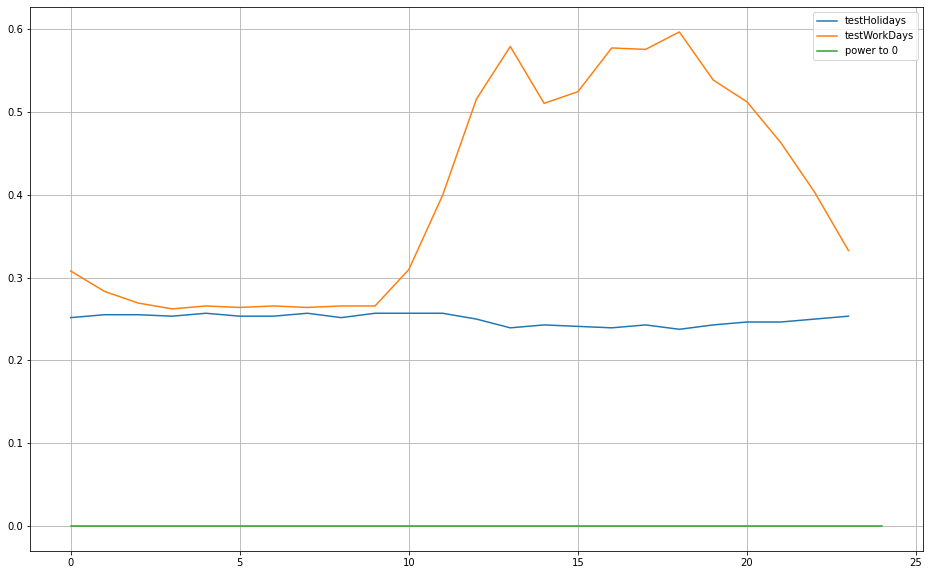

In [13]:
FIG_SIZE = (16,10)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot([hour for hour in range(24)], testHolidays[0], label='testHolidays')
ax.plot([hour for hour in range(24)], testWorkDays[0], label='testWorkDays')
ax.plot([0,24], [0,0], label='power to 0')
ax.grid()
ax.legend()
plt.show()

Now we build an autoencoder that is able to identify anomalies among **working days**.

Here we use an auto encoder with 5 hidden layers having respectively 50, 20, 2, 20, 50 neurons.

In [14]:
from tensorflow import keras

SIZE_SAMPLE = 24
#enconder
activationMode = 'swish'
encoderInput = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoder = keras.layers.Dense(50, activation=activationMode, name="1")(encoderInput)
secondLayerEncoder = keras.layers.Dense(20, activation=activationMode, name="2")(firstLayerEncoder)
encoderOutput = keras.layers.Dense(2, activation=activationMode, name="3")(secondLayerEncoder)

#decoder
firstLayerDecoder = keras.layers.Dense(20, activation=activationMode, name="4")(encoderOutput)
secondLayerDecoder = keras.layers.Dense(50, activation=activationMode, name="5")(firstLayerDecoder)
decoderOutput = keras.layers.Dense(24, activation=activationMode, name="6")(secondLayerDecoder)

#auto encoder
autoEncoder = keras.Model(encoderInput, decoderOutput)
autoEncoder.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
1 (Dense)                    (None, 50)                1250      
_________________________________________________________________
2 (Dense)                    (None, 20)                1020      
_________________________________________________________________
3 (Dense)                    (None, 2)                 42        
_________________________________________________________________
4 (Dense)                    (None, 20)                60        
_________________________________________________________________
5 (Dense)                    (None, 50)                1050      
_________________________________________________________________
6 (Dense)                    (None, 24)                1224  

Now we train the model to identify correctly normal working days, using trainingWorkingDays as training set.

In [15]:
BATCH_SIZE = 64
train = np.array(trainingWorkDays)
autoEncoder.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0.2)


Epoch 1/40
6/6 [==============================] - 2s 204ms/step - loss: 0.2025 - val_loss: 0.1462
Epoch 2/40
6/6 [==============================] - 0s 8ms/step - loss: 0.1944 - val_loss: 0.1374
Epoch 3/40
6/6 [==============================] - 0s 8ms/step - loss: 0.1861 - val_loss: 0.1226
Epoch 4/40
6/6 [==============================] - 0s 8ms/step - loss: 0.1612 - val_loss: 0.0986
Epoch 5/40
6/6 [==============================] - 0s 8ms/step - loss: 0.1279 - val_loss: 0.0644
Epoch 6/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0807 - val_loss: 0.0307
Epoch 7/40
6/6 [==============================] - 0s 8ms/step - loss: 0.0403 - val_loss: 0.0182
Epoch 8/40
6/6 [==============================] - 0s 10ms/step

With anomalous working days samples, mse is 0.08399782206767535
With working days samples, mse is 0.12291578983118225


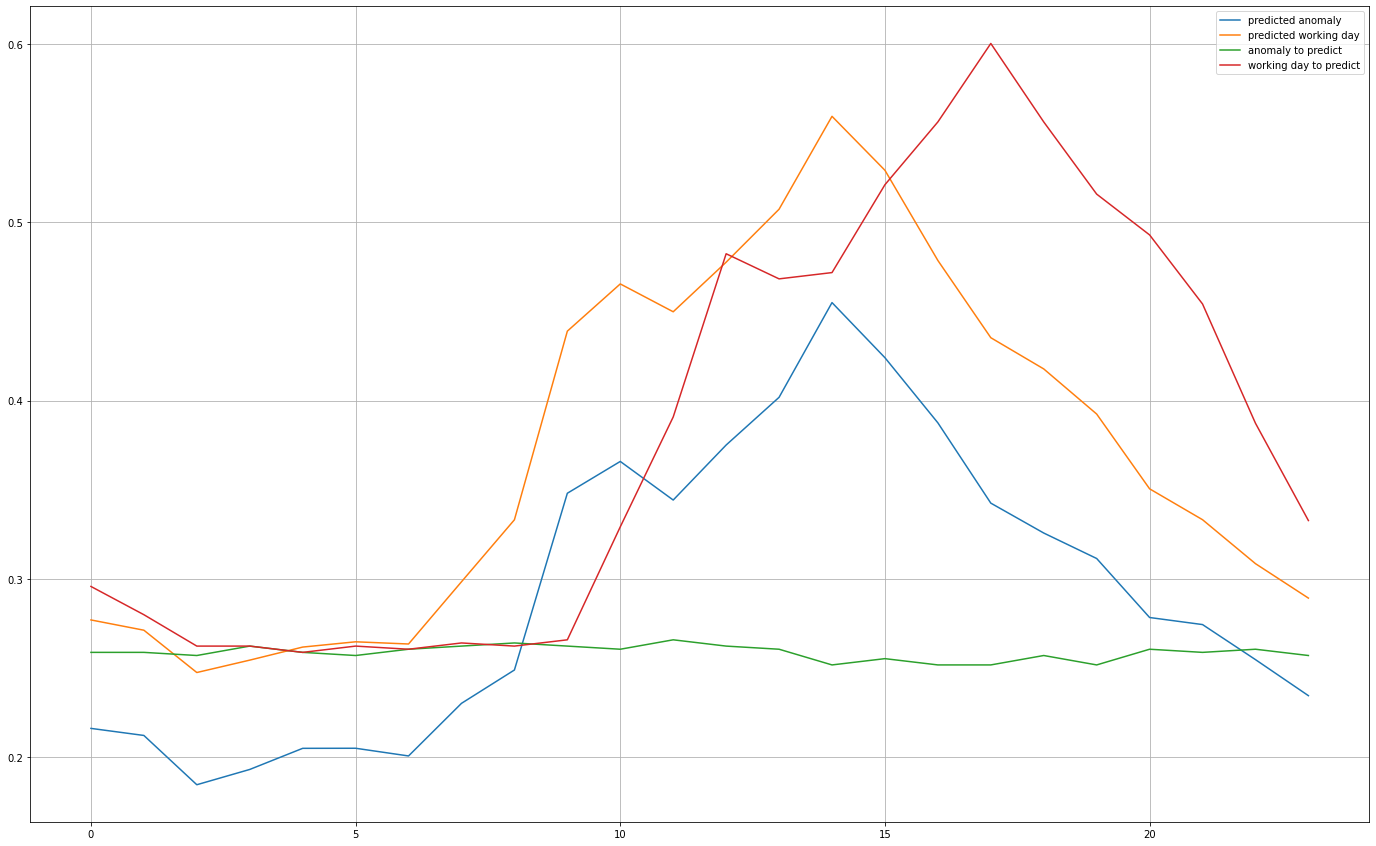

In [17]:
from sklearn import metrics

daysToPredict = workAnomaliesSamples
predictedValue = autoEncoder.predict(daysToPredict)
scoreAnomalousWorkingDays = np.sqrt(metrics.mean_squared_error(predictedValue, daysToPredict))

daysToPredict = testWorkDays
predictedValue = autoEncoder.predict(daysToPredict)
scoreWorkingDays = np.sqrt(metrics.mean_squared_error(predictedValue, daysToPredict))

print("With anomalous working days samples, mse is " + str(scoreAnomalousWorkingDays))
print("With working days samples, mse is " + str(scoreWorkingDays))

INDEX = 2
predictedAnomalousWorkingDay = autoEncoder.predict([workAnomaliesSamples[INDEX]])[0]
predictedWorkingDay = autoEncoder.predict([daysToPredict[INDEX]])[0]

fig, ax = plt.subplots(figsize=(24,15))
ax.plot([hour for hour in range(24)], predictedAnomalousWorkingDay, label='predicted anomaly')
ax.plot([hour for hour in range(24)], predictedWorkingDay, label='predicted working day')
ax.plot([hour for hour in range(24)], testHolidays[INDEX], label='anomaly to predict')
ax.plot([hour for hour in range(24)], daysToPredict[INDEX], label='working day to predict')
ax.grid()
ax.legend()
plt.show()


## K-MEANS
The second method used in order to detect anomalies is k-means algorithm.

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

pca = PCA(2)
datasetToKMEANS = pca.fit_transform(allSamples)
datasetToKMEANS.shape

(770, 2)

In [19]:
N_CENTROIDS = 5
label = KMeans(n_clusters=N_CENTROIDS, random_state=0).fit_predict(datasetToKMEANS)

for i in range(N_CENTROIDS):
    print("elements that belong to cluster {} are {}% of the samples".format(i, int(np.count_nonzero(label == i)/len(datasetToKMEANS) * 100 )))


elements that belong to cluster 0 are 11% of the samples
elements that belong to cluster 1 are 39% of the samples
elements that belong to cluster 2 are 23% of the samples
elements that belong to cluster 3 are 12% of the samples
elements that belong to cluster 4 are 13% of the samples


Now we verify the centroids with some predictions:

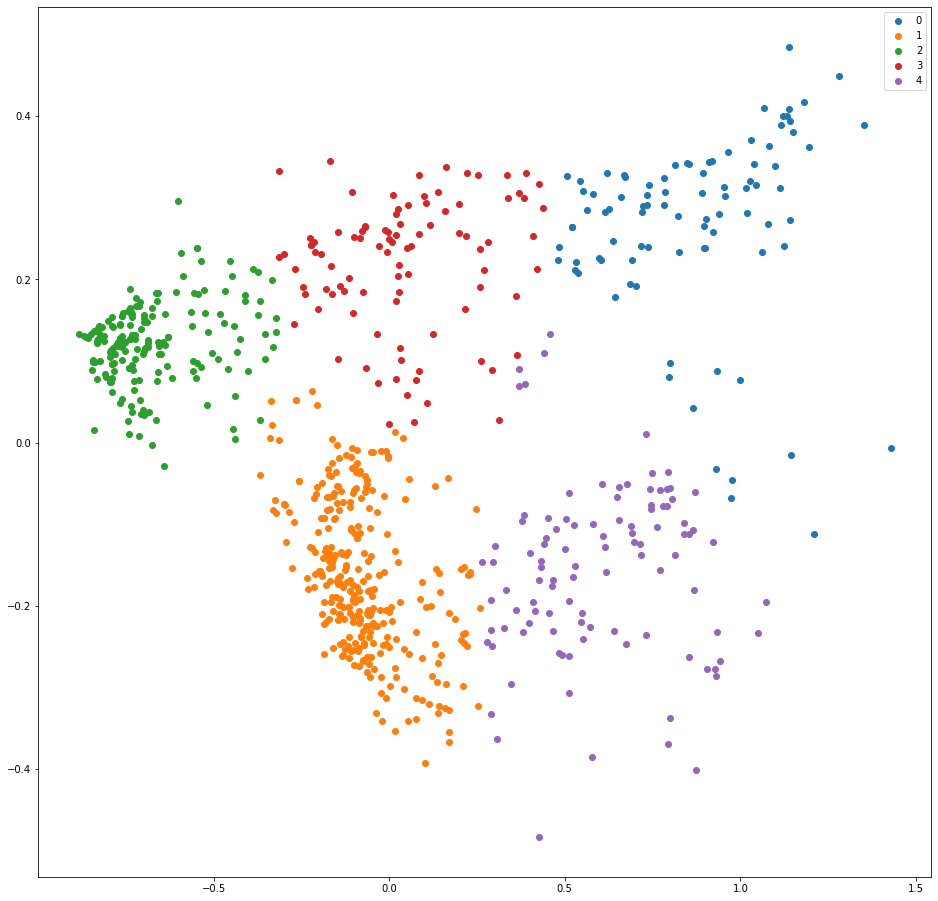

In [20]:
#Getting unique labels

unique_labels = np.unique(label)

#plotting the results:
plt.figure(figsize=(16, 16))
for i in unique_labels:
    plt.scatter(datasetToKMEANS[label == i , 0] , datasetToKMEANS[label == i , 1] , label = i)

plt.legend()
plt.show()



## LSTM
With an LSTM model, given the last 24 hours samples it can predict the next power sample: if the predicted value is similar
to the registered one, than the value is not anomalous.

As the input data is different from the previous, we need to build new sets:
- hours set, containing vectors of 24 hours.
- labels set, containing the next hours of each vector of hours set.


In [29]:
hourSamples = []
hourSpan = SAMPLES
daySpan = SAMPLES * 24

for hour in range(24):
    hourSamples.append([])

row = 0
for date in pd.date_range(start='2017-03-02', end='2019-04-09', freq='1h'):
    samplesPerDay = normalizedData[row : row + daySpan]
    hours = []
    for index in range(24):
        firstIndex = index * SAMPLES
        hours.append(samplesPerDay[firstIndex : firstIndex + SAMPLES].mean())
    hourSamples[date.hour].append(hours)
    row += hourSpan


In order to train the LSTM model we need to build a new list containing all the hours of 'hourSamples' and another one
containing the next hour for each element of the former list.

In [30]:
previousHours = []
labels = []

# the first 23 hours are introduced with the following nested loop
for hour in range(23):
    lastIndex = len(hourSamples[hour]) - 1
    for index in range(lastIndex):
        previousHours.append(hourSamples[hour][index])
        labels.append(hourSamples[hour][index][0])
    previousHours.append(hourSamples[hour][lastIndex])
    labels.append(hourSamples[hour + 1][0][0])

# last hour is introduced with the following loop
lastIndex = len(hourSamples[23]) - 1
for index in range(lastIndex):
    previousHours.append(hourSamples[23][index])
    labels.append(hourSamples[23][index + 1][0])

print("labels size is {}".format(len(labels)))
print("previous hours size is {}".format(len(previousHours)))

labels size is 18432
previous hours size is 18432


We take 80% data from the previous obtained lists to build training sets, whereas the remaining 20% are used to create
testing sets.

In [31]:
trainingSet = []
trainingLabels = []
testingSet = []
testingLabels = []

trainingSize = int(len(previousHours) * 0.8)
for index in range(trainingSize):
    trainingSet.append(previousHours[index])
    trainingLabels.append(labels[index])
for index in range(trainingSize, len(previousHours)):
    testingSet.append(previousHours[index])
    testingLabels.append(labels[index])

print("training set size is {}".format(len(trainingSet)))
print("training labels size is {}".format(len(trainingLabels)))

print("testing set size is {}".format(len(testingSet)))
print("testing labels size is {}".format(len(testingLabels)))


training set size is 14745
training labels size is 14745
testing set size is 3687
testing labels size is 3687


In [32]:
def reshape_set(set_to_convert, features):
    return set_to_convert.reshape((set_to_convert.shape[0], set_to_convert.shape[1], features))


trainingSet = np.array(trainingSet)
trainingLabels = np.array(trainingLabels)
testingSet = np.array(testingSet)
testingLabels = np.array(testingLabels)

FEATURES = 1

trainingSet = reshape_set(trainingSet, FEATURES)
testingSet = reshape_set(testingSet, FEATURES)

## LSTM
Given last 24 hours samples we can identify the next hour demand through LSTM inference.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import CuDNNLSTM, LSTM

ACTIVATION_MODE = 'relu'
hourForecaster = Sequential()

BATCH_SIZE = 64
NUM_SAMPLES = len(trainingSet)
TIME_STEPS = 24



hourForecaster.add(LSTM(units = 50, return_sequences = True, input_shape =(TIME_STEPS, FEATURES)))
hourForecaster.add(Dropout(0.2))
hourForecaster.add(Dense(units=20, activation=ACTIVATION_MODE))
hourForecaster.add(Dropout(0.2))
hourForecaster.add(Dense(units=10, activation=ACTIVATION_MODE))
hourForecaster.add(Dropout(0.2))
hourForecaster.add(Dense(units = 1, activation=ACTIVATION_MODE))
hourForecaster.compile(optimizer = Adam(learning_rate=0.0001), loss = 'mean_squared_error')

hourForecaster.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 50)            10400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 24, 50)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 24, 20)            1020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 24, 20)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 24, 10)            210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 10)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 24, 1)            

Training the LSTM model:

In [34]:
print(trainingLabels)

[0.32746479 0.44894366 0.38204225 ... 0.34507042 0.27992958 0.27640845]


In [35]:
hourForecaster.fit(trainingSet, trainingLabels, epochs = 40, batch_size = BATCH_SIZE, validation_data=(testingSet, testingLabels))

Epoch 1/40
231/231 [==============================] - 10s 32ms/step - loss: 0.0742 - val_loss: 0.0154

Once the last 24 hours are registered, we infer the next hour value and predict the closest cluster to the vector
composed by the last 23 hours registered, and the inferred value.
In order to identify the anomaly we must know which hour the samples refers to.

size of predicted values = 3687


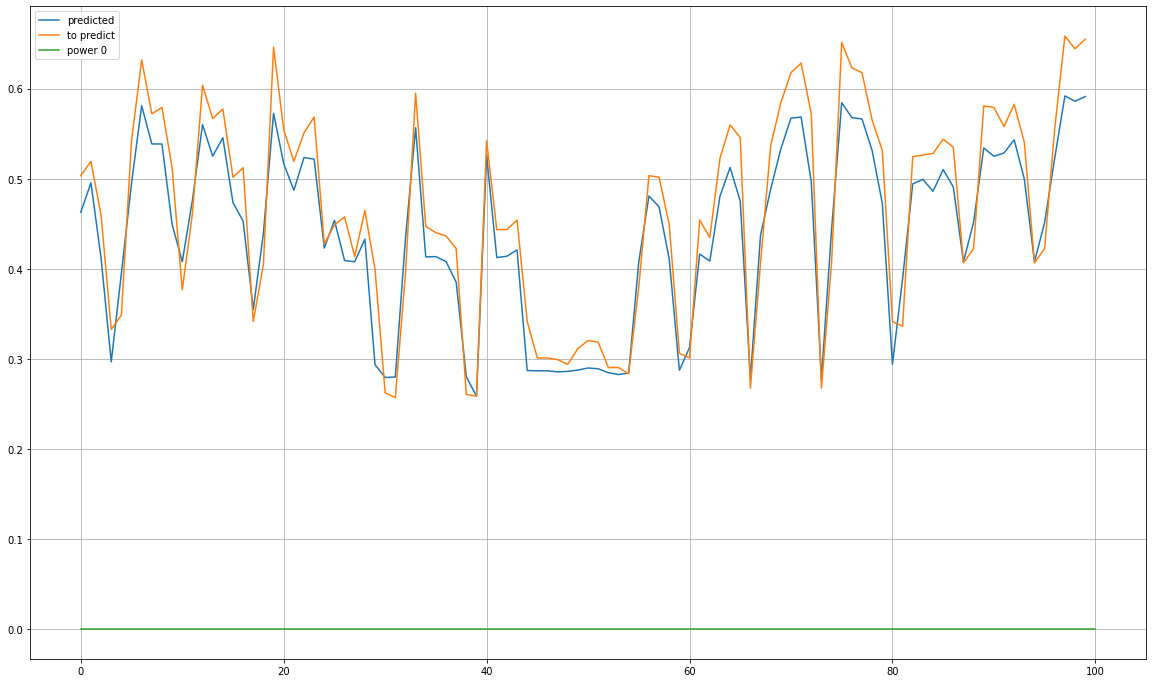

In [37]:
def convert_predicted_value(x):
    new_x = []
    for element in x:
        new_x.append(element[-1])
    return new_x

predictedValues = convert_predicted_value(hourForecaster.predict(testingSet))
print("size of predicted values = {}".format(len(predictedValues)))
START = 100
END = 200

fig, ax = plt.subplots(figsize=(20,12))
ax.plot([x for x in range(0, len(predictedValues[START:END]))], predictedValues[START:END], label="predicted")
ax.plot([x for x in range(0, len(testingLabels[START:END]))], testingLabels[START:END], label='to predict')
ax.plot([0, len(predictedValues[START:END])], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()